# Train DynUNet on Decathlon datasets
This tutorial shows how to train 3D segmentation tasks on all the 10 decathlon datasets with `DynUNet`.

Refer to papers:

`Automated Design of Deep Learning Methods for Biomedical Image Segmentation <https://arxiv.org/abs/1904.08128>`

`nnU-Net: Self-adapting Framework for U-Net-Based Medical Image Segmentation <https://arxiv.org/abs/1809.10486>`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/dynunet_tutorial.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai[nibabel, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
# FIXME: install MONAI from source code, will remove it when v0.5.0 released
%pip install git+https://github.com/Project-MONAI/MONAI#egg=MONAI

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import shutil
import sys
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.engines import SupervisedEvaluator, SupervisedTrainer
from monai.handlers import (
    CheckpointSaver,
    LrScheduleHandler,
    MeanDice,
    StatsHandler,
    ValidationHandler,
)
from monai.inferers import SimpleInferer, SlidingWindowInferer
from monai.losses import DiceCELoss
from monai.networks.nets import DynUNet
from monai.transforms import (
    AddChanneld,
    AsDiscreted,
    CastToTyped,
    Compose,
    CropForegroundd,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandCropByPosNegLabeld,
    RandFlipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandScaleIntensityd,
    RandZoomd,
    Spacingd,
    SpatialPadd,
    ToTensord,
)

print_config()

MONAI version: 0.4.0+86.gadb2f7f.dirty
Numpy version: 1.19.1
Pytorch version: 1.7.0a0+8deb4fe
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: adb2f7fa7a0f9cb519614f6ec6f3a7f43601d9c9

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.1.0
Tensorboard version: 1.15.0+nv
gdown version: 3.12.2
TorchVision version: 0.8.0a0
ITK version: 5.1.2
tqdm version: 4.56.2
lmdb version: 0.99
psutil version: 5.7.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Select Decathlon task
The Decathlon dataset contains 10 tasks, this dynUNet tutorial can support all of them.

Just need to select task ID and other parameters will be automatically selected.

(Tested task 04 locally, epoch time is 8 secs on V100 GPU and best metrics is 0.8828 at epoch: 70)

In [2]:
task_id = "04"

task_name = {
    "01": "Task01_BrainTumour",
    "02": "Task02_Heart",
    "03": "Task03_Liver",
    "04": "Task04_Hippocampus",
    "05": "Task05_Prostate",
    "06": "Task06_Lung",
    "07": "Task07_Pancreas",
    "08": "Task08_HepaticVessel",
    "09": "Task09_Spleen",
    "10": "Task10_Colon",
}

patch_size = {
    "01": [128, 128, 128],
    "02": [160, 192, 80],
    "03": [128, 128, 128],
    "04": [40, 56, 40],
    "05": [320, 256, 20],
    "06": [192, 160, 80],
    "07": [224, 224, 40],
    "08": [192, 192, 64],
    "09": [192, 160, 64],
    "10": [192, 160, 56],
}

spacing = {
    "01": [1.0, 1.0, 1.0],
    "02": [1.25, 1.25, 1.37],
    "03": [0.77, 0.77, 1],
    "04": [1.0, 1.0, 1.0],
    "05": [0.62, 0.62, 3.6],
    "06": [0.79, 0.79, 1.24],
    "07": [0.8, 0.8, 2.5],
    "08": [0.8, 0.8, 1.5],
    "09": [0.79, 0.79, 1.6],
    "10": [0.78, 0.78, 3],
}

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical/


## Define train and validation transforms

In [5]:
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Spacingd(
            keys=["image", "label"],
            pixdim=spacing[task_id],
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        SpatialPadd(keys=["image", "label"], spatial_size=patch_size[task_id]),
        NormalizeIntensityd(keys=["image"], nonzero=False, channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=patch_size[task_id],
            pos=1,
            neg=1,
            num_samples=1,
            image_key="image",
            image_threshold=0,
        ),
        RandZoomd(
            keys=["image", "label"],
            min_zoom=0.9,
            max_zoom=1.2,
            mode=("trilinear", "nearest"),
            align_corners=(True, None),
            prob=0.16,
        ),
        CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
        RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
        RandGaussianSmoothd(
            keys=["image"],
            sigma_x=(0.5, 1.15),
            sigma_y=(0.5, 1.15),
            sigma_z=(0.5, 1.15),
            prob=0.15,
        ),
        RandScaleIntensityd(keys=["image"], factors=0.3, prob=0.15),
        RandFlipd(["image", "label"], spatial_axis=[0, 1, 2], prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Spacingd(
            keys=["image", "label"],
            pixdim=spacing[task_id],
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        SpatialPadd(keys=["image", "label"], spatial_size=patch_size[task_id]),
        NormalizeIntensityd(keys=["image"], nonzero=False, channel_wise=True),
        CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
        ToTensord(keys=["image", "label"]),
    ]
)

## Load data by MONAI DecathlonDataset

In [6]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task=task_name[task_id],
    transform=train_transform,
    section="training",
    download=False,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=1)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task=task_name[task_id],
    transform=val_transform,
    section="validation",
    download=False,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)

Loading dataset: 100%|██████████| 52/52 [00:00<00:00, 144.63it/s]


## Visualize batch of data to check images and labels

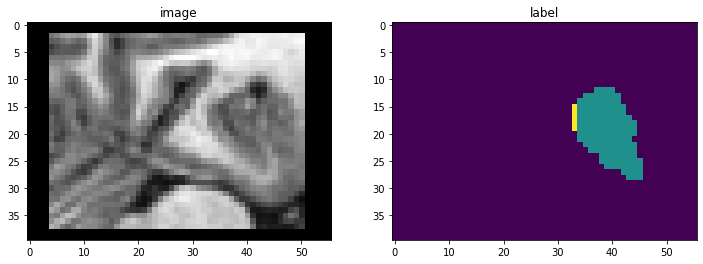

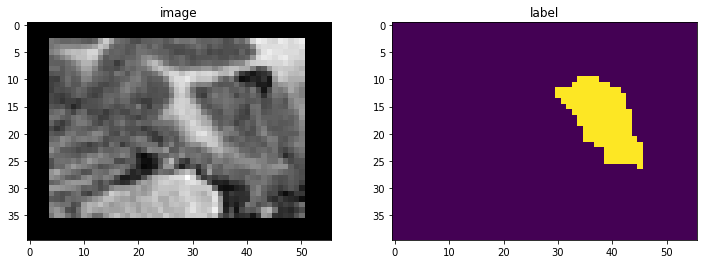

In [7]:
for i in range(2):
    image, label = val_ds[i]["image"], val_ds[i]["label"]
    plt.figure("check", (12, 8))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[0, :, :, 10].detach().cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[0, :, :, 10].detach().cpu())
    plt.show()

## Initialize training components

In [8]:
device = torch.device("cuda:0")
loss = DiceCELoss(to_onehot_y=True, softmax=True, batch=False)
learning_rate = 0.01
max_epochs = 200

sizes, spacings = patch_size[task_id], spacing[task_id]
properties = val_ds.get_properties(keys=["labels", "modality"])
n_class, in_channels = len(properties["labels"]), len(properties["modality"])
best_dice, best_epoch = (n_class - 1) * [0], (n_class - 1) * [0]
strides, kernels = [], []

while True:
    spacing_ratio = [sp / min(spacings) for sp in spacings]
    stride = [
        2 if ratio <= 2 and size >= 8 else 1
        for (ratio, size) in zip(spacing_ratio, sizes)
    ]
    kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
    if all(s == 1 for s in stride):
        break
    sizes = [i / j for i, j in zip(sizes, stride)]
    spacings = [i * j for i, j in zip(spacings, stride)]
    kernels.append(kernel)
    strides.append(stride)
strides.insert(0, len(spacings) * [1])
kernels.append(len(spacings) * [3])
net = DynUNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=n_class,
    kernel_size=kernels,
    strides=strides,
    upsample_kernel_size=strides[1:],
    norm_name="instance",
    deep_supervision=True,
    deep_supr_num=2,
    res_block=False,
).to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.95)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda epoch: (1 - epoch / max_epochs) ** 0.9
)

## MONAI evaluator
Here we customized the forward computation, so need to define `_iteration` function.

In [9]:

val_handlers = [
    StatsHandler(output_transform=lambda x: None),
    CheckpointSaver(
        save_dir="./runs/", save_dict={"net": net}, save_key_metric=True
    ),
]

val_post_transform = Compose(
    [
        AsDiscreted(
            keys=("pred", "label"),
            argmax=(True, False),
            to_onehot=True,
            n_classes=n_class,
        )
    ]
)

# Define customized evaluator


class DynUNetEvaluator(SupervisedEvaluator):
    def _iteration(self, engine, batchdata):
        inputs, targets = self.prepare_batch(batchdata)
        inputs, targets = inputs.to(engine.state.device), targets.to(
            engine.state.device
        )
        flip_inputs = torch.flip(inputs, dims=(2, 3, 4))

        def _compute_pred():
            pred = self.inferer(inputs, self.network)
            flip_pred = torch.flip(
                self.inferer(flip_inputs, self.network), dims=(2, 3, 4)
            )
            return (pred + flip_pred) / 2

        # execute forward computation
        self.network.eval()
        with torch.no_grad():
            if self.amp:
                with torch.cuda.amp.autocast():
                    predictions = _compute_pred()
            else:
                predictions = _compute_pred()
        return {"image": inputs, "label": targets, "pred": predictions}


evaluator = DynUNetEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=net,
    inferer=SlidingWindowInferer(
        roi_size=patch_size[task_id], sw_batch_size=4, overlap=0.5
    ),
    post_transform=val_post_transform,
    key_val_metric={
        "val_mean_dice": MeanDice(
            include_background=False,
            output_transform=lambda x: (x["pred"], x["label"]),
        )
    },
    val_handlers=val_handlers,
    amp=True,
)

## MONAI trainer
Here we customized loss computation progress, so need to define `_iteration` function.

In [10]:

train_handlers = [
    LrScheduleHandler(lr_scheduler=scheduler, print_lr=True),
    ValidationHandler(validator=evaluator, interval=2, epoch_level=True),
    StatsHandler(tag_name="train_loss", output_transform=lambda x: x["loss"]),
]

# define customized trainer


class DynUNetTrainer(SupervisedTrainer):
    def _iteration(self, engine, batchdata):
        inputs, targets = self.prepare_batch(batchdata)
        inputs, targets = inputs.to(engine.state.device), targets.to(
            engine.state.device
        )

        def _compute_loss(preds, label):
            if len(preds.size()) - len(targets.size()) == 1:
                # In deep supervision mode, The shape of the preds is
                # in the form of (Batch, deep_supr_num, C, H, W, D),
                # thus they should be unbinded into a list of feature
                # maps each has the shape (Batch, C, H, W, D)
                preds = torch.unbind(preds, dim=1)
            return sum(
                0.5 ** i * self.loss_function.forward(p, label)
                for i, p in enumerate(preds)
            )

        self.network.train()
        self.optimizer.zero_grad()
        if self.amp and self.scaler is not None:
            with torch.cuda.amp.autocast():
                predictions = self.inferer(inputs, self.network)
                loss = _compute_loss(predictions, targets)
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
        else:
            predictions = self.inferer(inputs, self.network)
            loss = _compute_loss(predictions, targets).mean()
            loss.backward()
            self.optimizer.step()
        return {
            "image": inputs,
            "label": targets,
            "pred": predictions,
            "loss": loss.item(),
        }


trainer = DynUNetTrainer(
    device=device,
    max_epochs=max_epochs,
    train_data_loader=train_loader,
    network=net,
    optimizer=optimizer,
    loss_function=loss,
    inferer=SimpleInferer(),
    post_transform=None,
    key_train_metric=None,
    train_handlers=train_handlers,
    amp=True,
)

## Execute training with workflows

In [12]:

logging.basicConfig(stream=sys.stdout, level=logging.INFO)


trainer.run()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)